# Entrenamiento y exploración del dimensionamiento de los datos

In [1]:
import os
import sys
import torch
import pickle

from torch                          import nn
from utilit_exploracion             import get_exp_name, load_data, apply_autoreject, split_dataset, seed_np_rng

from sklearn.utils.class_weight     import compute_class_weight
from sklearn.metrics                import confusion_matrix, classification_report, balanced_accuracy_score

from skorch.helper                  import predefined_split
from skorch.callbacks               import Checkpoint, EarlyStopping, EpochScoring, LRScheduler

from braindecode                    import EEGClassifier
from braindecode.util               import set_random_seeds
from braindecode.models             import SleepStagerChambon2018

sys.path.append(os.path.abspath(os.path.join('../../..','03 Dynamic-Spatial-Filtering')))
from models                         import DynamicSpatialFilter
from transforms                     import Compose

In [2]:
cuda   = torch.cuda.is_available()  # check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

if cuda:
    torch.backends.cudnn.enabled       = True
    torch.backends.cudnn.benchmark     = not True # args.deterministic
    torch.backends.cudnn.deterministic = True     # args.deterministic

In [3]:
# definicion de variables

save_dir           = './runs/pc18_debug/'
denoising          = 'autoreject'
dataset            = 'pc18_debug'
model              = 'stager_net'
dsf_type           = 'dsfd'
dsf_n_out_channels = None
cosine_annealing   = True
n_conv_chs         = 16
dropout            = 0.5
seed               = 87
n_jobs             = 4
window_size_s      = 30
valid_size         = 0.2
test_size          = 0.2
random_state_valid = 87
random_state_test  = 87
patience           = 2
n_epochs           = 2
weight_decay       = 0.001
num_workers        = 4 
batch_size         = 64
lr                 = 0.0004
  

In [4]:
# create savedir

dir_name  = get_exp_name(dataset, model, dsf_type, denoising) # 'no_denoising')
save_path = os.path.join(save_dir, dir_name)

if not os.path.exists(save_path):
    os.makedirs(save_path)

In [ ]:
# load, preprocess and window data

windows_dataset = load_data('pc18_debug', 30, 4)
if  denoising == 'autoreject':
    windows_dataset = apply_autoreject(windows_dataset, seed, n_jobs)

In [12]:
# split into train, valid and test sets

available_classes = windows_dataset.get_metadata()['target'].unique()

train_set, valid_set, test_set = split_dataset(
                                                windows_dataset, 
                                                valid_size,                    
                                                test_size,                    
                                                random_state_valid = 87, 
                                                random_state_test  = 87  
                                              )
del windows_dataset

In [13]:
# extract weights to balance the loss function

y_true_train = train_set.get_metadata()['target'].to_numpy()
train_weights = torch.Tensor(compute_class_weight('balanced', classes=available_classes, y=y_true_train)).to(device)

### Create model

In [14]:
# set random seed to be able to reproduce results

set_random_seeds(seed, cuda = cuda)

In [15]:
# extract number of channels and time steps from dataset

n_classes  = len(available_classes)
n_channels = train_set[0][0].shape[0]

print(n_classes)
print(n_channels)

5
4


In [16]:
if dsf_type != 'vanilla':
    if dsf_type == 'dsfd':
        mlp_input       = 'log_diag_cov'
        dsf_soft_thresh = False
    elif dsf_type == 'dsfm_st':
        mlp_input       = 'logm_cov_eig'
        dsf_soft_thresh = True

        # Use CPU to compute logm, it's faster than pytorch with cuda
        train_set.transform = logm_cov if train_set.transform[0] is None \
            else Compose([train_set.transform[0], logm_cov])
        valid_set.transform = logm_cov
        test_set.transform  = logm_cov

    else:
        raise ValueError(
            f'dsf_type must be None, dsfd or dsfm_st, got {dsf_type}')
    
    dsf = DynamicSpatialFilter(
                                n_channels, 
                                mlp_input=mlp_input, 
                                n_out_channels       = dsf_n_out_channels, 
                                apply_soft_thresh    = dsf_soft_thresh
                              )
    n_channels = dsf.n_out_channels

input_size_samples  = len(train_set.datasets[0].windows.times)
sfreq               = train_set.datasets[0].windows.info['sfreq']


anexo - conociendo un poco los datos

In [135]:
data = train_set.datasets[0].windows.get_data()
data.shape

(768, 4, 3000)

train_set[0][0] == a data[ 0, :, :]

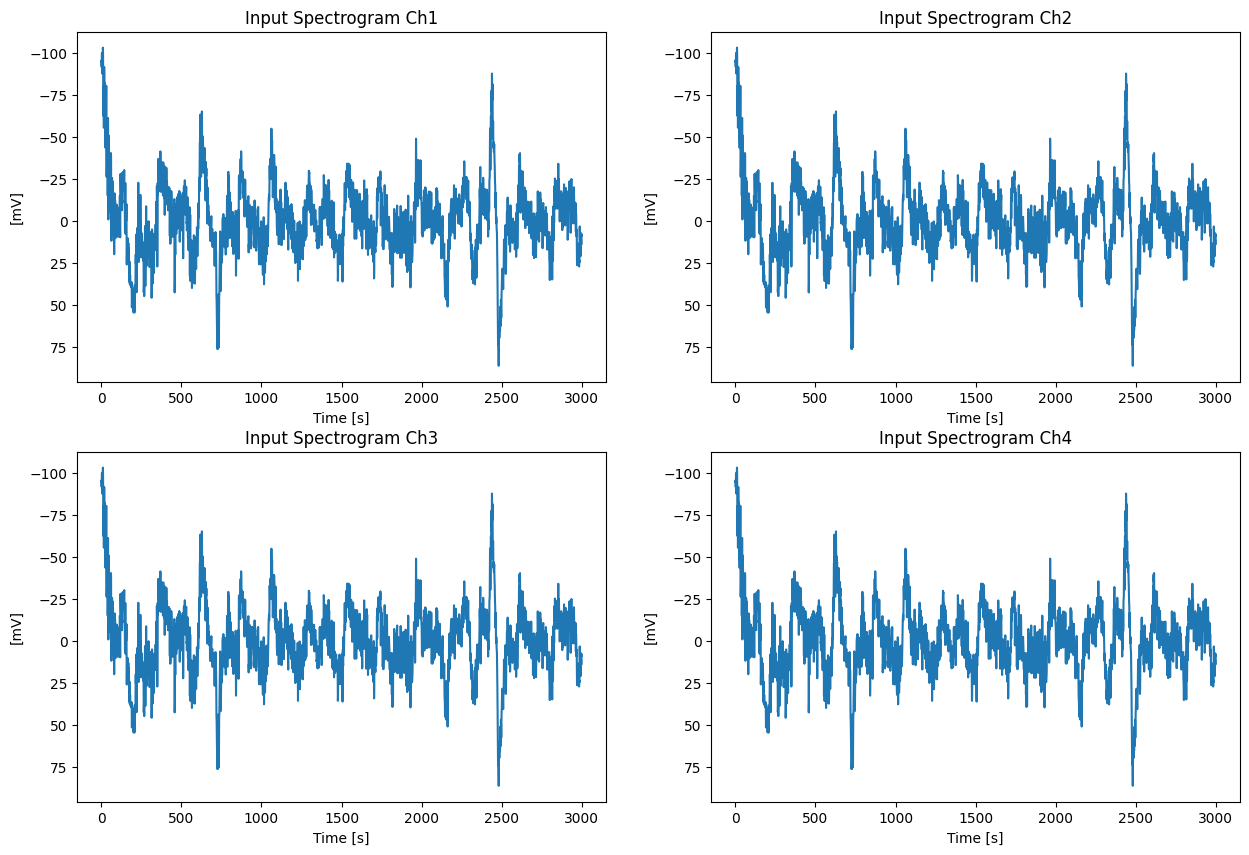

In [91]:
import matplotlib.pyplot as plt

# visualización de los 4 canales juntos de dato con seizure
fig,axs = plt.subplots(2, 2, figsize = (15,10))

# Canal 1
axs[0,0].plot(data[2, 0, : ])
axs[0,0].invert_yaxis()
axs[0,0].set_title("Input Spectrogram Ch1")
axs[0,0].set_ylabel("[mV]")
axs[0,0].set_xlabel("Time [s]")

# Canal 2
axs[0,1].plot(data[2, 0, : ])
axs[0,1].invert_yaxis()
axs[0,1].set_title("Input Spectrogram Ch2")
axs[0,1].set_ylabel("[mV]")
axs[0,1].set_xlabel("Time [s]")

# Canal 3
axs[1,0].plot(data[2, 0, : ])
axs[1,0].invert_yaxis()
axs[1,0].set_title("Input Spectrogram Ch3")
axs[1,0].set_ylabel("[mV]")
axs[1,0].set_xlabel("Time [s]")

# Canal 4
axs[1,1].plot(data[2, 0, : ])
axs[1,1].invert_yaxis()
axs[1,1].set_title("Input Spectrogram Ch4")
axs[1,1].set_ylabel("[mV]")
axs[1,1].set_xlabel("Time [s]")

plt.show()

anexo - conociendo un poco los datos

In [17]:
if model == 'stager_net':
    model = SleepStagerChambon2018(
                                    n_channels, 
                                    sfreq, 
                                    n_conv_chs       = n_conv_chs,
                                    input_size_s     = input_size_samples / sfreq, 
                                    pad_size_s       = 0.1,
                                    n_classes        = n_classes, 
                                    dropout          = dropout, 
                                    apply_batch_norm =True
                                  )
    model.to(device)
else:
    raise NotImplementedError

Este model, entiendo que seria iESPnet en nuestro caso y se pone en secuencial con DSF

In [18]:
if dsf_type != 'vanilla':
    model = nn.Sequential(dsf, model)
n_params  = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nModel has {n_params} trainable parameters.\n')

if torch.cuda.device_count() > 1:  # Parallelize model over GPUs
    print(f'\nUsing {torch.cuda.device_count()} GPUs.\n')
    model = nn.DataParallel(model)


Model has 18641 trainable parameters.



### Train and evaluate model

In [19]:
cp             = Checkpoint(dirname = save_path)
early_stopping = EarlyStopping(patience = patience)
train_bal_acc  = EpochScoring(
                               scoring         = 'balanced_accuracy', 
                               on_train        = True, 
                               name            = 'train_bal_acc',
                               lower_is_better = False
                             )
valid_bal_acc  = EpochScoring(
                               scoring         = 'balanced_accuracy', 
                               on_train        = False, 
                               name            = 'valid_bal_acc',
                               lower_is_better = False
                             )

callbacks = [
            ('cp', cp),
            ('patience', early_stopping),
            ('train_bal_acc', train_bal_acc),
            ('valid_bal_acc', valid_bal_acc),
            ]

In [20]:
if cosine_annealing:
    callbacks.append(('lr_scheduler', LRScheduler('CosineAnnealingLR', T_max = n_epochs - 1)))

In [21]:
net = EEGClassifier(
                    module                          = model,
                    criterion                       = torch.nn.CrossEntropyLoss,
                    criterion__weight               = train_weights,
                    optimizer                       = torch.optim.AdamW,
                    optimizer__weight_decay         = weight_decay,
                    train_split                     = predefined_split(valid_set),
                    optimizer__lr                   = lr,
                    max_epochs                      = n_epochs,
                    batch_size                      = batch_size,
                    iterator_train__shuffle         = True,
                    iterator_train__num_workers     = num_workers,
                    iterator_valid__num_workers     = num_workers,
                    iterator_train__worker_init_fn  = seed_np_rng,
                    callbacks                       = callbacks,
                    device                          = device
                   )

In [22]:
# Obtener las etiquetas del conjunto de entrenamiento
y_train = train_set.get_metadata()['target'].to_numpy()

# Asegúrate de que 'train_set' y 'y_train' tengan el mismo orden y tamaño
assert len(train_set)== len(y_train)

In [23]:
net.fit(train_set, y = y_train)

---------------------------------------------
DynamicSpatialFilter input shape: torch.Size([64, 4, 3000])
After reshaping: torch.Size([64, 1, 4, 3000])
SpatialFeatureExtractor input shape: torch.Size([64, 1, 4, 3000])
SpatialFeatureExtractor output shape 1: torch.Size([64, 1, 4])
SpatialFeatureExtractor output shape 2: torch.Size([64, 1, 4])
MLP output shape: torch.Size([64, 1, 20])
W shape: torch.Size([64, 1, 4, 4])
Bias shape: torch.Size([64, 1, 4, 1])
Output shape: torch.Size([64, 1, 4, 3000])
---------------------------------------------
DynamicSpatialFilter input shape: torch.Size([64, 4, 3000])
After reshaping: torch.Size([64, 1, 4, 3000])
SpatialFeatureExtractor input shape: torch.Size([64, 1, 4, 3000])
SpatialFeatureExtractor output shape 1: torch.Size([64, 1, 4])
SpatialFeatureExtractor output shape 2: torch.Size([64, 1, 4])
MLP output shape: torch.Size([64, 1, 20])
W shape: torch.Size([64, 1, 4, 4])
Bias shape: torch.Size([64, 1, 4, 1])
Output shape: torch.Size([64, 1, 4, 300

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=Sequential(
    (0): DynamicSpatialFilter(
      (feat_extractor): SpatialFeatureExtractor()
      (mlp): Sequential(
        (0): Linear(in_features=4, out_features=4, bias=True)
        (1): ReLU()
        (2): Linear(in_features=4, out_features=20, bias=True)
      )
    )
    (1): SleepStagerChambon2018(
      (spatial_conv): Conv2d(1, 4, kernel_size=(4, 1), stride=(1, 1))
      (feature_extractor): Sequential(
        (0): Conv2d(1, 16, kernel_size=(1, 50), stride=(1, 1), padding=(0, 10))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=(1, 13), stride=(1, 13), padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(16, 16, kernel_size=(1, 50), stride=(1, 1), padding=(0, 10))
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU()
        (7): MaxPool2d(

In [129]:
# load best model

net.initialize()
net.load_params(checkpoint=cp)

# Pickle best model
with open(os.path.join(save_path, 'best_model.pkl'), 'wb') as f:
    net.train_split = None  # Avoid pickling the validation set
    pickle.dump(net, f)

Re-initializing module.
Re-initializing criterion because the following parameters were re-set: weight.
Re-initializing optimizer.


In [130]:
# evaluate performance

y_true_test  = test_set.get_metadata()['target'].to_numpy()
y_pred_test  = net.predict(test_set)
test_bal_acc = balanced_accuracy_score(y_true_test, y_pred_test) * 100

print('\nTest results:\n-------------\n')
print(f'Balanced accuracy: {test_bal_acc:0.2f}%\n')
print('Confusion matrix:')
print(confusion_matrix(y_true_test, y_pred_test))
print('\nClassification report:')
print(classification_report(y_true_test, y_pred_test))


Test results:
-------------

Balanced accuracy: 25.00%

Confusion matrix:
[[243   2  52  15   0]
 [ 45   0  12   1   0]
 [193   1  59  14   0]
 [ 38   0  16  18   0]
 [ 71   5   5   0   0]]

Classification report:
              precision    recall  f1-score   support

           0       0.41      0.78      0.54       312
           1       0.00      0.00      0.00        58
           2       0.41      0.22      0.29       267
           3       0.38      0.25      0.30        72
           4       0.00      0.00      0.00        81

    accuracy                           0.41       790
   macro avg       0.24      0.25      0.23       790
weighted avg       0.34      0.41      0.34       790



/home/martin/Documentos/environments/env_dsf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/martin/Documentos/environments/env_dsf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/martin/Documentos/environments/env_dsf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,